In [1]:
import os
import sys 
os.chdir('..')
sys.path.insert(0, os.getcwd())
import glob
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader, TensorDataset
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from pathlib import Path


from AE_pipeline_pytorch import SemiSupAE
from train_semisupae_Subject import GaitBatchIterable 


from torch.optim import AdamW
from sklearn.metrics import r2_score

import umap
import hdbscan

import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import (
    confusion_matrix, ConfusionMatrixDisplay,
      accuracy_score, classification_report,
      adjusted_rand_score, normalized_mutual_info_score,
    silhouette_score, davies_bouldin_score, homogeneity_score, completeness_score, v_measure_score,
    calinski_harabasz_score, f1_score, roc_auc_score
)
from sklearn.mixture import GaussianMixture
from collections import Counter
from sklearn.manifold import TSNE


from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize




Using device: cuda


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
#Load the model from the checkpoint
#ckpt_path = Path("checkpoints_3groups_subject/semisupae_subject_last.pt")
ckpt_path = Path("runs/semisup_3groups_20251119_124802/semisupae_last.pt")
ckpt = torch.load(ckpt_path, map_location=device)

model = SemiSupAE(
        steps=100,
        in_dim=321,
        latent=128,
        n_group=3,
        n_nuisance=None,
    ).to(device)

model.load_state_dict(ckpt["model"])   
model.eval()


/tmp/ipykernel_525636/788636260.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(ckpt_path, map_location=device)


SemiSupAE(
  (encoder): BiLSTMEncoder(
    (bilstm): LSTM(321, 128, batch_first=True, bidirectional=True)
    (to_latent): Sequential(
      (0): Linear(in_features=256, out_features=128, bias=True)
      (1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
    )
  )
  (decoder): LSTMDecoder(
    (init): Linear(in_features=128, out_features=128, bias=True)
    (lstm): LSTM(128, 128, batch_first=True)
    (out): Linear(in_features=128, out_features=321, bias=True)
  )
  (group_head): HeadMLP(
    (net): Sequential(
      (0): Linear(in_features=128, out_features=64, bias=True)
      (1): ReLU()
      (2): Linear(in_features=64, out_features=3, bias=True)
    )
  )
  (proj_head): ProjectionHead(
    (net): Sequential(
      (0): Linear(in_features=128, out_features=128, bias=True)
      (1): ReLU()
      (2): Linear(in_features=128, out_features=128, bias=True)
    )
  )
)

In [4]:
# test Dataloader with meta info
test_path = "test_cycles.zarr" 

#patients_per_batch = 8
#samples_per_patient = 8
#micro_batch = patients_per_batch * samples_per_patient
accum_steps = 1

micro_batch = 4096
num_workers = 8
prefetch = 6

test_loader = DataLoader(
    GaitBatchIterable(test_path, batch_size=micro_batch, return_meta=True),
    batch_size=None,
    num_workers=num_workers,
    pin_memory=True,
    persistent_workers=False,
    prefetch_factor=prefetch,
)

# Get one batch to inspect what the loader returns
batch = next(iter(test_loader))

if isinstance(batch, (list, tuple)) and len(batch) > 1:
    x_example, meta_example = batch
else:
    x_example, meta_example = batch, None

print("x_example shape:", x_example.shape)
print("meta_example type:", type(meta_example))

if isinstance(meta_example, dict):
    print("meta keys:", meta_example.keys())
elif isinstance(meta_example, torch.Tensor):
    print("meta_example shape:", meta_example.shape)

# Check model output
x_example = x_example.to(device)
with torch.no_grad():
    out_example = model(x_example, return_all=True)

print("model output type:", type(out_example))
if isinstance(out_example, dict):
    print("Keys in model output:", out_example.keys())

x_example shape: torch.Size([4096, 100, 321])
meta_example type: <class 'torch.Tensor'>
meta_example shape: torch.Size([4096, 100, 5])
model output type: <class 'dict'>
Keys in model output: dict_keys(['z', 'recon', 'logits', 'proj'])


In [5]:
#Function to extract latent
def get_latent_from_semisup(out, use_proj=False):
    """
    Extract latent representation from SemiSupAE output dict.

    use_proj = False -> use encoder latent 'z'
    use_proj = True  -> use projection head 'proj'
    """
    if not isinstance(out, dict):
        raise TypeError("Expected dict output from model(x, return_all=True).")
    
    if use_proj:
        if "proj" not in out:
            raise KeyError("'proj' not found in model output keys: " + str(out.keys()))
        return out["proj"]
    else:
        if "z" not in out:
            raise KeyError("'z' not found in model output keys: " + str(out.keys()))
        return out["z"]



In [6]:
# latents, groups, subject_ids
latents_list = []
groups_list  = []
subjects_list = []

model.eval()
with torch.no_grad():
    for x_batch, meta in test_loader:
        # ----- 1) Latentes -----
        x_batch = x_batch.to(device)
        out = model(x_batch, return_all=True)
        z = get_latent_from_semisup(out, use_proj=False)
        latents_list.append(z.cpu().numpy())

        # ----- 2) Subject ID -----
        # meta: [B, 100, 5]
        # usar canal 0 en timestep 0
        subj_codes = meta[:, 0, 0].long().cpu().numpy()
        subjects_list.append(subj_codes)

        # ----- 3) Group codes -----
        # canal 1 en timestep 0
        group_codes = meta[:, 0, 1].long().cpu().numpy()
        groups_list.append(group_codes)

latents     = np.concatenate(latents_list, axis=0)
subject_ids = np.concatenate(subjects_list, axis=0)
groups      = np.concatenate(groups_list,  axis=0)

print("latents:", latents.shape)
print("subject_ids:", subject_ids.shape)
print("groups:", groups.shape)

print("unique subjects:", np.unique(subject_ids))
print("unique groups:",   np.unique(groups))



latents: (61440, 128)
subject_ids: (61440,)
groups: (61440,)
unique subjects: [  2   8  13  18  21  42  49  75  76  82 120 125 175]
unique groups: [1 2 3]


# Evaluation and reconstruction 

In [7]:
def get_recon(out):
    # dict (semisup), tuple (AE) o tensor
    if isinstance(out, dict):
        return out["recon"]
    if isinstance(out, tuple):
        return out[0]
    return out


In [8]:
# Reconstruct and evaluate on a subset of cycles for specific variables (SEMISUP AE)
selected_vars = [313, 311, 306]   # indices along feature dimension (last dim)
MAX_CYCLES   = 200
BATCH_SIZE   = 16
epsilon      = 1e-8

# ─── 1. Reservoir sampling (without storing the whole dataset) ───────────
reservoir = []   # will store up to MAX_CYCLES cycles (tensors on CPU)
n_seen = 0

model.eval()
with torch.no_grad():
    for batch in test_loader:
        if isinstance(batch, (list, tuple)) and len(batch) == 2:
            x_batch, meta = batch
        else:
            x_batch = batch
            meta = None
        x_cpu = x_batch.cpu()
        
        for cycle in x_cpu:                   # each cycle: [T, C]
            n_seen += 1
            if len(reservoir) < MAX_CYCLES:
                reservoir.append(cycle)
            else:
                j = np.random.randint(0, n_seen)
                if j < MAX_CYCLES:
                    reservoir[j] = cycle

M = len(reservoir)
print(f"Reservoir sampling: {M} cycles stored (out of {n_seen} seen).")

# ─── 2. DataLoader only for sampled cycles ───────────────────────────────
# sample_cycles shape: [M, T, C]
sample_cycles = torch.stack(reservoir)        
sample_loader = DataLoader(
    sample_cycles,
    batch_size=BATCH_SIZE,
    shuffle=False,
)

# ─── 3. Reconstruction and metrics on selected_vars ──────────────────────
sum_mse, sum_mae, sum_mape = 0.0, 0.0, 0.0
count = 0

model.eval()
with torch.no_grad():
    for batch_x in sample_loader:
        # batch_x: [B, T, C]
        batch_x = batch_x.to(device)

        out   = model(batch_x)            # default forward (no return_all)
        recon = get_recon(out)           # [B, T, C]

        # Select variables of interest along last dimension
        x_orig = batch_x[..., selected_vars]   # [B, T, len(vars)]
        x_rec  = recon  [..., selected_vars]

        err = x_orig - x_rec
        # mean over time and variables
        mse_b  = err.pow(2).mean(dim=(1, 2)).cpu().numpy()
        mae_b  = err.abs().mean(dim=(1, 2)).cpu().numpy()
        mape_b = (err.abs() / (x_orig.abs() + epsilon)).mean(dim=(1, 2)).cpu().numpy() * 100

        sum_mse  += mse_b.sum()
        sum_mae  += mae_b.sum()
        sum_mape += mape_b.sum()
        count    += mse_b.shape[0]

mse_global  = sum_mse  / count
mae_global  = sum_mae  / count
mape_global = sum_mape / count

print(f"\nEvaluation over {count} sampled cycles:")
print(f"  MSE:  {mse_global:.6f}")
print(f"  MAE:  {mae_global:.6f}")
print(f"  MAPE: {mape_global:.2f}%")


Reservoir sampling: 200 cycles stored (out of 61440 seen).

Evaluation over 200 sampled cycles:
  MSE:  0.343234
  MAE:  0.444018
  MAPE: 348.69%


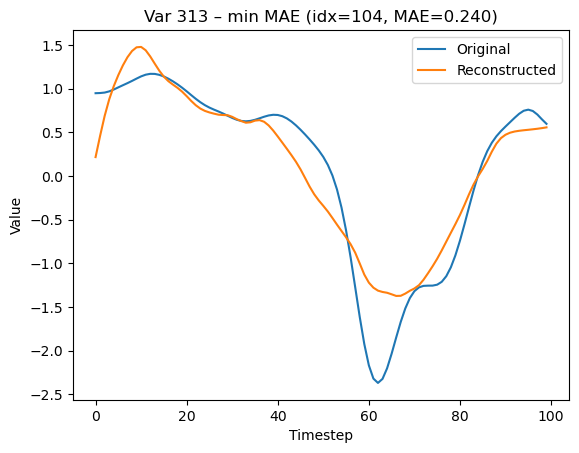

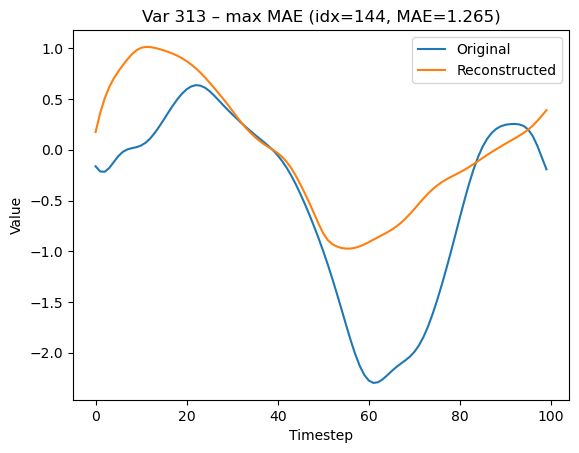

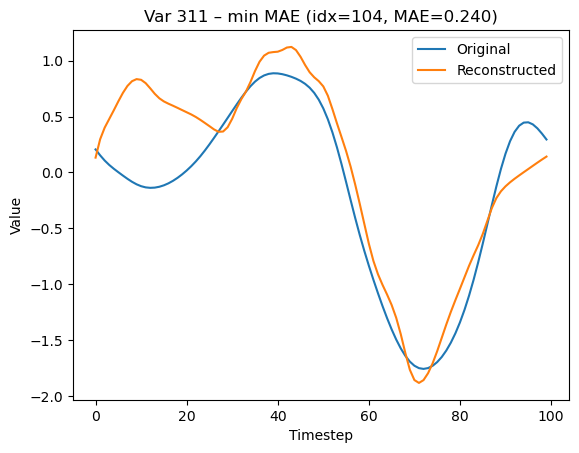

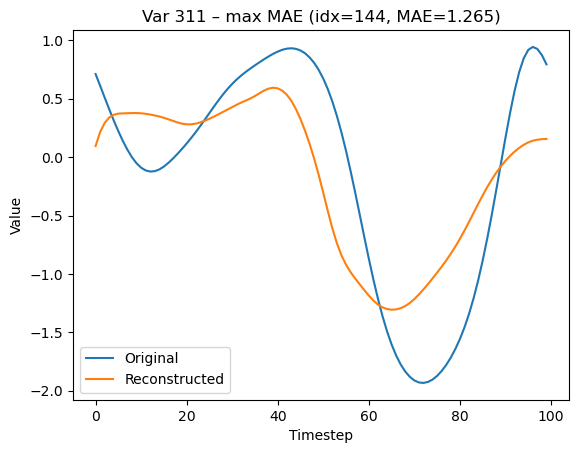

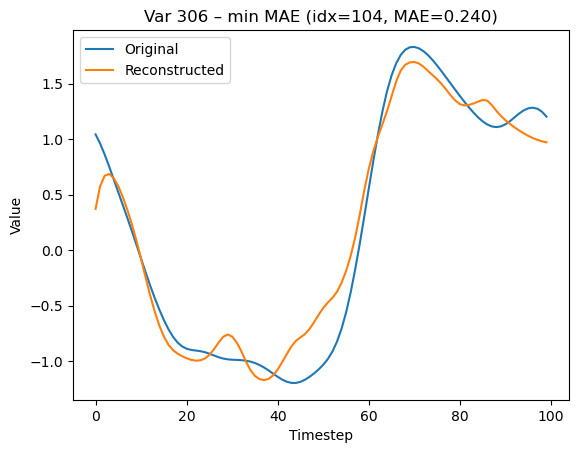

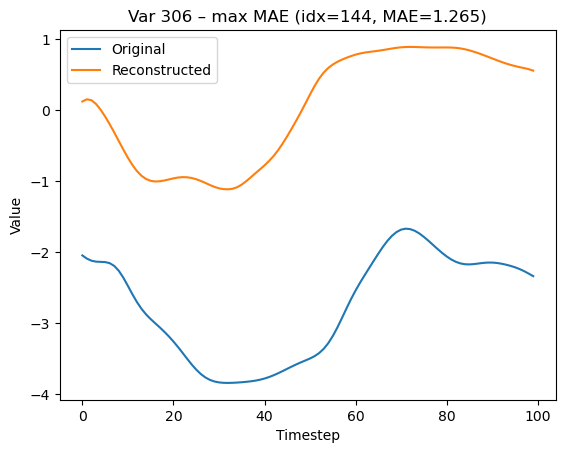

In [10]:
# ─── Reconstruction Visualization  ─────────────────────────────────────────────────
selected_vars = [313, 311, 306]   # variables to plot
BATCH_SIZE    = 16

# sample_cycles is the tensor [M, T, C] obtained with reservoir sampling
plot_loader = DataLoader(sample_cycles, batch_size=BATCH_SIZE, shuffle=False)

orig_list, recon_list, mae_list = [], [], []

model.eval()
with torch.no_grad():
    for batch_x in plot_loader:
        # batch_x: [B, T, C]
        batch_x = batch_x.to(device)

        # Forward pass: get reconstruction
        out   = model(batch_x)
        recon = get_recon(out)           # [B, T, C]

        # Select variables of interest
        x_orig = batch_x[..., selected_vars].cpu().numpy()   # (B, T, 3)
        x_rec  = recon  [..., selected_vars].cpu().numpy()   # (B, T, 3)

        # MAE per cycle
        err       = np.abs(x_orig - x_rec)                   # (B, T, 3)
        mae_batch = err.mean(axis=(1, 2))                    # (B,)

        orig_list.append(x_orig)
        recon_list.append(x_rec)
        mae_list.append(mae_batch)

orig_cycles  = np.concatenate(orig_list,  axis=0)  # (M, T, 3)
recon_cycles = np.concatenate(recon_list, axis=0)  # (M, T, 3)
mae_cycles   = np.concatenate(mae_list,   axis=0)  # (M,)

idx_min = np.argmin(mae_cycles)
idx_max = np.argmax(mae_cycles)
T = orig_cycles.shape[1]

# ─── Plot best and worst reconstruction for each variable ───────
for i, var in enumerate(selected_vars):
    # Best reconstruction
    plt.figure()
    plt.plot(np.arange(T), orig_cycles[idx_min, :, i],  label="Original")
    plt.plot(np.arange(T), recon_cycles[idx_min, :, i], label="Reconstructed")
    plt.title(f"Var {var} – min MAE (idx={idx_min}, MAE={mae_cycles[idx_min]:.3f})")
    plt.xlabel("Timestep")
    plt.ylabel("Value")
    plt.legend()
    plt.show()
    plt.close()

    # Worst reconstruction
    plt.figure()
    plt.plot(np.arange(T), orig_cycles[idx_max, :, i],  label="Original")
    plt.plot(np.arange(T), recon_cycles[idx_max, :, i], label="Reconstructed")
    plt.title(f"Var {var} – max MAE (idx={idx_max}, MAE={mae_cycles[idx_max]:.3f})")
    plt.xlabel("Timestep")
    plt.ylabel("Value")
    plt.legend()
    plt.show()
    plt.close()


# Clustering group

=== KMeans on SemiSupAE latent ===
Silhouette: 0.1768
ARI:        0.3100
NMI:        0.3487

=== External metrics (KMeans) ===
Homogeneity:  0.3333
Completeness: 0.3656
V-measure:    0.3487

=== Cluster Purity (KMeans) ===
Cluster 0: Purity = 0.8783, size = 16669
Cluster 1: Purity = 0.5841, size = 33551
Cluster 2: Purity = 0.8447, size = 11220

Accuracy after cluster→group mapping: 0.712


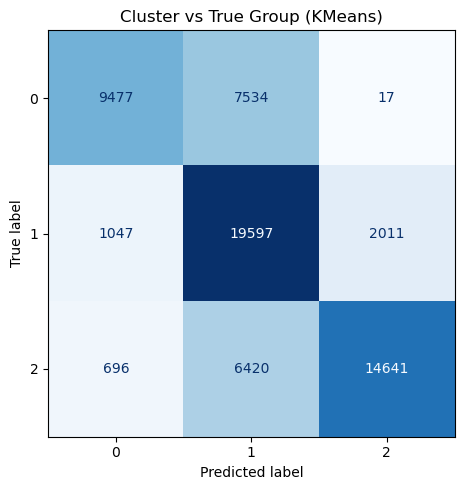

In [7]:
# ─── KMeans clustering on SemiSupAE latents ───────────────────────────────

N_CLUSTERS = 3
RANDOM_STATE = 42

kmeans = KMeans(
    n_clusters=N_CLUSTERS,
    n_init=10,
    random_state=RANDOM_STATE
)
cluster_labels = kmeans.fit_predict(latents)

sil = silhouette_score(latents, cluster_labels)
ari = adjusted_rand_score(groups, cluster_labels)
nmi = normalized_mutual_info_score(groups, cluster_labels)
print("=== KMeans on SemiSupAE latent ===")
print(f"Silhouette: {sil:.4f}")
print(f"ARI:        {ari:.4f}")
print(f"NMI:        {nmi:.4f}")

#External metrics
h = homogeneity_score(groups, cluster_labels)
c = completeness_score(groups, cluster_labels)
v = v_measure_score(groups, cluster_labels)
print("\n=== External metrics (KMeans) ===")
print(f"Homogeneity:  {h:.4f}")
print(f"Completeness: {c:.4f}")
print(f"V-measure:    {v:.4f}")

#Purity 
print("\n=== Cluster Purity (KMeans) ===")
for c in np.unique(cluster_labels):
    idxs = np.where(cluster_labels == c)[0]
    true_groups = groups[idxs]
    purity = np.max(np.bincount(true_groups)) / len(true_groups)
    print(f"Cluster {c}: Purity = {purity:.4f}, size = {len(idxs)}")


# Map each cluster to the most common true group inside it
mapping = {}
for c in np.unique(cluster_labels):
    idxs = np.where(cluster_labels == c)[0]
    most_common = Counter(groups[idxs]).most_common(1)[0][0]
    mapping[c] = most_common

aligned = np.vectorize(mapping.get)(cluster_labels)

acc = (aligned == groups).mean()
cm  = confusion_matrix(groups, aligned)

print(f"\nAccuracy after cluster→group mapping: {acc:.3f}")

fig, ax = plt.subplots(figsize=(5, 5))
disp = ConfusionMatrixDisplay(cm)
disp.plot(cmap="Blues", ax=ax, values_format="d", colorbar=False)
ax.set_title("Cluster vs True Group (KMeans)")
plt.tight_layout()
plt.show()




/home/dmartinez/miniconda3/envs/gait_env/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/dmartinez/miniconda3/envs/gait_env/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Unique HDBSCAN labels: [-1  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]

=== HDBSCAN on SemiSupAE latent ===
Clusters found (excluding noise): 20
ARI: 0.3483
NMI: 0.6135

=== External metrics (HDBSCAN) ===
Homogeneity:  1.0000
Completeness: 0.4425
V-measure:    0.6135

=== Cluster Purity (HDBSCAN) ===
Cluster 0: Purity = 1.0000, size = 470
Cluster 1: Purity = 1.0000, size = 2318
Cluster 2: Purity = 1.0000, size = 268
Cluster 3: Purity = 1.0000, size = 116
Cluster 4: Purity = 1.0000, size = 685
Cluster 5: Purity = 1.0000, size = 118
Cluster 6: Purity = 1.0000, size = 122
Cluster 7: Purity = 1.0000, size = 2992
Cluster 8: Purity = 1.0000, size = 5962
Cluster 9: Purity = 1.0000, size = 7882
Cluster 10: Purity = 1.0000, size = 8038
Cluster 11: Purity = 1.0000, size = 7018
Cluster 12: Purity = 1.0000, size = 5854
Cluster 13: Purity = 1.0000, size = 162
Cluster 14: Purity = 1.0000, size = 117
Cluster 15: Purity = 1.0000, size = 1990
Cluster 16: Purity = 1.0000, size = 226
Clu

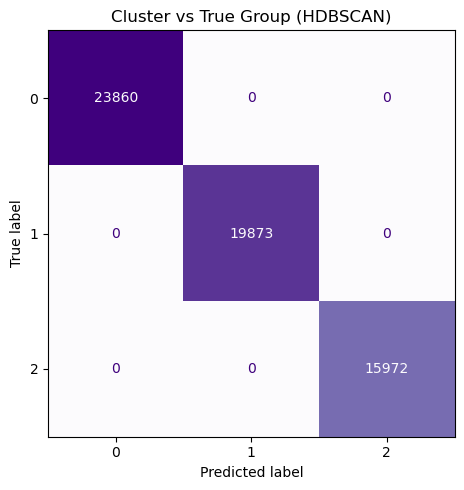


Noise ratio (HDBSCAN): 2.82%


In [7]:
#HDBSCAN clustering on SemiSupAE latents ───────────────────────────────
hdb = hdbscan.HDBSCAN(
    min_cluster_size=100,   # tune depending on N
    min_samples=20,
    metric="euclidean",
)

hdb_labels = hdb.fit_predict(latents)  # -1 = noise
np.save("HDBSCAN_labels.npy", hdb_labels)

print("Unique HDBSCAN labels:", np.unique(hdb_labels))

# Filter out noise (-1) for metrics
mask = hdb_labels != -1
hdb_valid    = hdb_labels[mask]
groups_valid = groups[mask]



ari_hdb = adjusted_rand_score(groups_valid, hdb_valid)
nmi_hdb = normalized_mutual_info_score(groups_valid, hdb_valid)

print("\n=== HDBSCAN on SemiSupAE latent ===")
print("Clusters found (excluding noise):", len(np.unique(hdb_valid)))
print(f"ARI: {ari_hdb:.4f}")
print(f"NMI: {nmi_hdb:.4f}")

# External eval
h = homogeneity_score(groups_valid, hdb_valid)
c = completeness_score(groups_valid, hdb_valid)
v = v_measure_score(groups_valid, hdb_valid)

print("\n=== External metrics (HDBSCAN) ===")
print(f"Homogeneity:  {h:.4f}")
print(f"Completeness: {c:.4f}")
print(f"V-measure:    {v:.4f}")

# Purity
print("\n=== Cluster Purity (HDBSCAN) ===")
for cu in np.unique(hdb_valid):
    idxs = np.where(hdb_valid == cu)[0]
    purity = np.max(np.bincount(groups_valid[idxs])) / len(idxs)
    print(f"Cluster {cu}: Purity = {purity:.4f}, size = {len(idxs)}")

# Internal metrics
sil_hdb = silhouette_score(latents[mask], hdb_valid)
ch_hdb  = calinski_harabasz_score(latents[mask], hdb_valid)
db_hdb  = davies_bouldin_score(latents[mask], hdb_valid)

print("\n=== Internal structure metrics (HDBSCAN) ===")
print(f"Silhouette:          {sil_hdb:.4f}")
print(f"Calinski–Harabasz:   {ch_hdb:.1f}")
print(f"Davies–Bouldin:      {db_hdb:.4f}")

# Cluster→group mapping
mapping_hdb = {}
for cu in np.unique(hdb_valid):
    idxs = np.where(hdb_valid == cu)[0]
    most_common = Counter(groups_valid[idxs]).most_common(1)[0][0]
    mapping_hdb[cu] = most_common

aligned_hdb = np.vectorize(mapping_hdb.get)(hdb_valid)
acc_hdb = (aligned_hdb == groups_valid).mean()
print(f"\nAccuracy after cluster→group mapping: {acc_hdb:.3f}")

# Confusion Matrix
cm_hdb = confusion_matrix(groups_valid, aligned_hdb)

fig, ax = plt.subplots(figsize=(5, 5))
ConfusionMatrixDisplay(cm_hdb).plot(cmap="Purples", ax=ax, values_format="d", colorbar=False)
ax.set_title("Cluster vs True Group (HDBSCAN)")
plt.tight_layout()
plt.show()

# Noise ratio
noise_ratio = np.mean(hdb_labels == -1)
print(f"\nNoise ratio (HDBSCAN): {noise_ratio*100:.2f}%")


Unique GMM labels: [0 1 2]

=== GMM on SemiSupAE latent ===
Silhouette: 0.0986
ARI:        0.2368
NMI:        0.2795

=== External metrics (GMM) ===
Homogeneity:  0.2758
Completeness: 0.2833
V-measure:    0.2795

=== Cluster Purity (GMM) ===
Cluster 0: Purity = 0.6356, size = 24830
Cluster 1: Purity = 0.6564, size = 12978
Cluster 2: Purity = 0.5419, size = 23632

=== Internal structure metrics (GMM) ===
Calinski–Harabasz: 7842.7
Davies–Bouldin:    2.5371

Accuracy after cluster→group mapping: 0.604


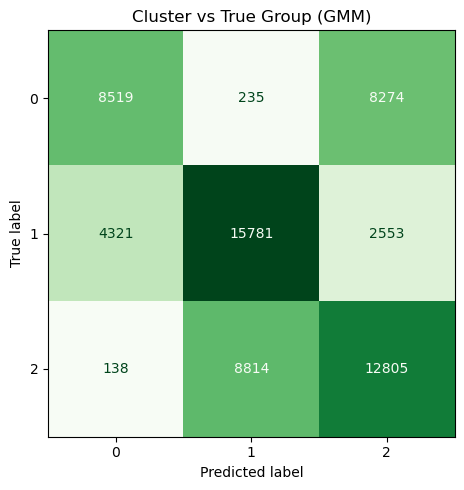

In [9]:
#Gaussian Mixture Model on SemiSupAE latents
N_COMPONENTS = 3
RANDOM_STATE = 42

gmm = GaussianMixture(
    n_components=N_COMPONENTS,
    covariance_type="full",   # you can try "diag" as well
    n_init=20,
    random_state=RANDOM_STATE
)

gmm.fit(latents)
gmm_labels = gmm.predict(latents)
np.save("gmm_labels.npy", gmm_labels)
print("Unique GMM labels:", np.unique(gmm_labels))

# ── Basic external metrics ────────────────────────────────────────────────
sil_gmm = silhouette_score(latents, gmm_labels)
ari_gmm = adjusted_rand_score(groups, gmm_labels)
nmi_gmm = normalized_mutual_info_score(groups, gmm_labels)

print("\n=== GMM on SemiSupAE latent ===")
print(f"Silhouette: {sil_gmm:.4f}")
print(f"ARI:        {ari_gmm:.4f}")
print(f"NMI:        {nmi_gmm:.4f}")

# ── External evaluation: homogeneity / completeness / V-measure ──────────
h_gmm = homogeneity_score(groups, gmm_labels)
c_gmm = completeness_score(groups, gmm_labels)
v_gmm = v_measure_score(groups, gmm_labels)

print("\n=== External metrics (GMM) ===")
print(f"Homogeneity:  {h_gmm:.4f}")
print(f"Completeness: {c_gmm:.4f}")
print(f"V-measure:    {v_gmm:.4f}")

# ── Cluster purity ────────────────────────────────────────────────────────
print("\n=== Cluster Purity (GMM) ===")
for cu in np.unique(gmm_labels):
    idxs = np.where(gmm_labels == cu)[0]
    # groups must be integer-coded for bincount
    purity = np.max(np.bincount(groups[idxs])) / len(idxs)
    print(f"Cluster {cu}: Purity = {purity:.4f}, size = {len(idxs)}")

# ── Internal structure metrics ────────────────────────────────────────────
ch_gmm = calinski_harabasz_score(latents, gmm_labels)
db_gmm = davies_bouldin_score(latents, gmm_labels)

print("\n=== Internal structure metrics (GMM) ===")
print(f"Calinski–Harabasz: {ch_gmm:.1f}")
print(f"Davies–Bouldin:    {db_gmm:.4f}")

# ── Cluster → group mapping (majority vote) ──────────────────────────────
mapping_gmm = {}
for cu in np.unique(gmm_labels):
    idxs = np.where(gmm_labels == cu)[0]
    most_common = Counter(groups[idxs]).most_common(1)[0][0]
    mapping_gmm[cu] = most_common

aligned_gmm = np.vectorize(mapping_gmm.get)(gmm_labels)
acc_gmm = (aligned_gmm == groups).mean()
print(f"\nAccuracy after cluster→group mapping: {acc_gmm:.3f}")

# ── Confusion matrix ─────────────────────────────────────────────────────
cm_gmm = confusion_matrix(groups, aligned_gmm)

fig, ax = plt.subplots(figsize=(5, 5))
ConfusionMatrixDisplay(cm_gmm).plot(
    cmap="Greens",
    ax=ax,
    values_format="d",
    colorbar=False
)
ax.set_title("Cluster vs True Group (GMM)")
plt.tight_layout()
plt.show()

In [ ]:
#Agglomerative Clustering on SemiSupAE latents

In [ ]:
#SOM

## UMAP Visualizations

/home/dmartinez/miniconda3/envs/gait_env/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


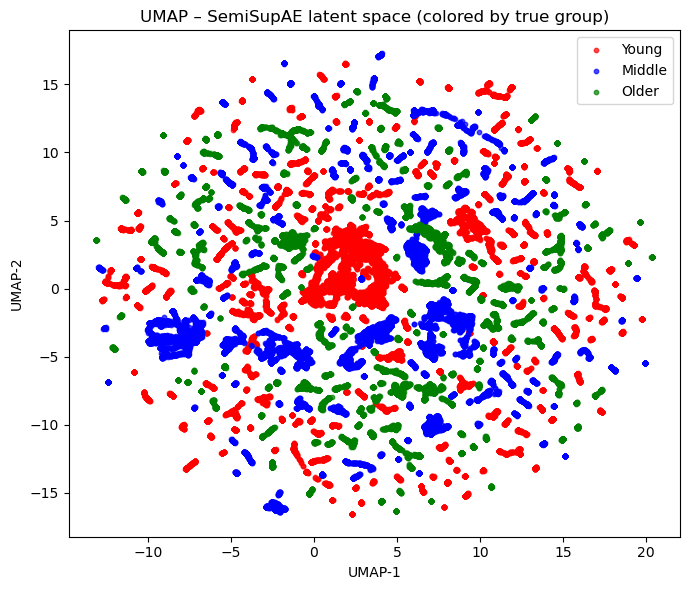

In [14]:
# ─── UMAP visualization by true group ─────────────────────────────────────

import umap
import matplotlib.pyplot as plt

umap_model = umap.UMAP(
    n_neighbors=25,
    min_dist=0.15,
    metric="euclidean",
    random_state=42,
)

latents_umap = umap_model.fit_transform(latents)

plt.figure(figsize=(7, 6))
group_names = {1: "Young", 2: "Middle", 3: "Older"}
colors = {1:"red", 2:"blue", 3:"green"}

for g in np.unique(groups):
    g = int(g)
    mask = (groups == g)
    plt.scatter(
        latents_umap[mask, 0],
        latents_umap[mask, 1],
        s=10,
        alpha=0.7,
        c=colors[g],
        label=group_names[g],
    )

plt.title("UMAP – SemiSupAE latent space (colored by true group)")
plt.xlabel("UMAP-1"); plt.ylabel("UMAP-2")
plt.legend()
plt.tight_layout()
plt.show()


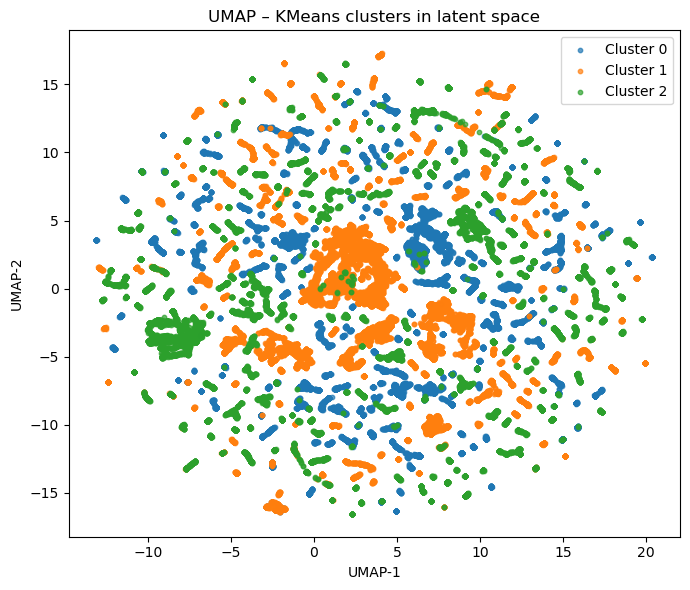

In [15]:
# ─── UMAP visualization by KMeans clusters ───────────────────────────────

plt.figure(figsize=(7, 6))

unique_k = np.unique(cluster_labels)
cmap = plt.get_cmap("tab10")

for i, cu in enumerate(unique_k):
    mask = (cluster_labels == cu)
    plt.scatter(
        latents_umap[mask, 0],
        latents_umap[mask, 1],
        s=10,
        alpha=0.7,
        color=cmap(i),
        label=f"Cluster {cu}",
    )

plt.title("UMAP – KMeans clusters in latent space")
plt.xlabel("UMAP-1"); plt.ylabel("UMAP-2")
plt.legend()
plt.tight_layout()
plt.show()


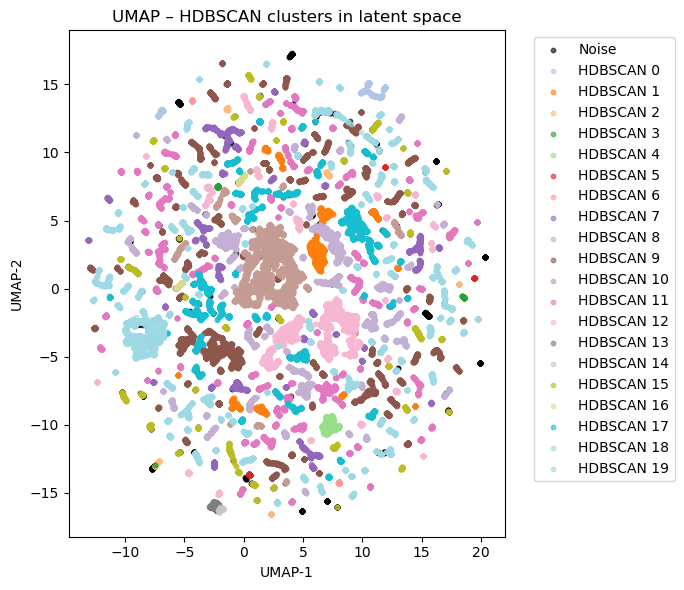

In [16]:
# ─── UMAP visualization by HDBSCAN clusters ──────────────────────────────

plt.figure(figsize=(7, 6))

unique_h = np.unique(hdb_labels)
cmap = plt.get_cmap("tab20")

for i, cu in enumerate(unique_h):
    mask = (hdb_labels == cu)

    if cu == -1:
        color = "black"
        label = "Noise"
    else:
        color = cmap(i)
        label = f"HDBSCAN {cu}"

    plt.scatter(
        latents_umap[mask, 0],
        latents_umap[mask, 1],
        s=10,
        alpha=0.6,
        color=color,
        label=label,
    )

plt.title("UMAP – HDBSCAN clusters in latent space")
plt.xlabel("UMAP-1"); plt.ylabel("UMAP-2")
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()


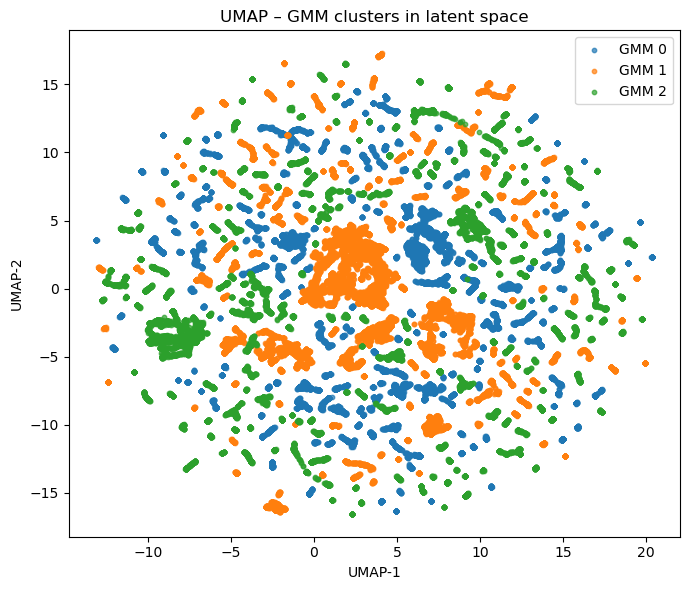

In [17]:
# ─── UMAP visualization by GMM clusters ──────────────────────────────────

plt.figure(figsize=(7, 6))

unique_g = np.unique(gmm_labels)
cmap = plt.get_cmap("tab10")

for i, cu in enumerate(unique_g):
    mask = (gmm_labels == cu)
    plt.scatter(
        latents_umap[mask, 0],
        latents_umap[mask, 1],
        s=10,
        alpha=0.7,
        color=cmap(i),
        label=f"GMM {cu}",
    )

plt.title("UMAP – GMM clusters in latent space")
plt.xlabel("UMAP-1"); plt.ylabel("UMAP-2")
plt.legend()
plt.tight_layout()
plt.show()


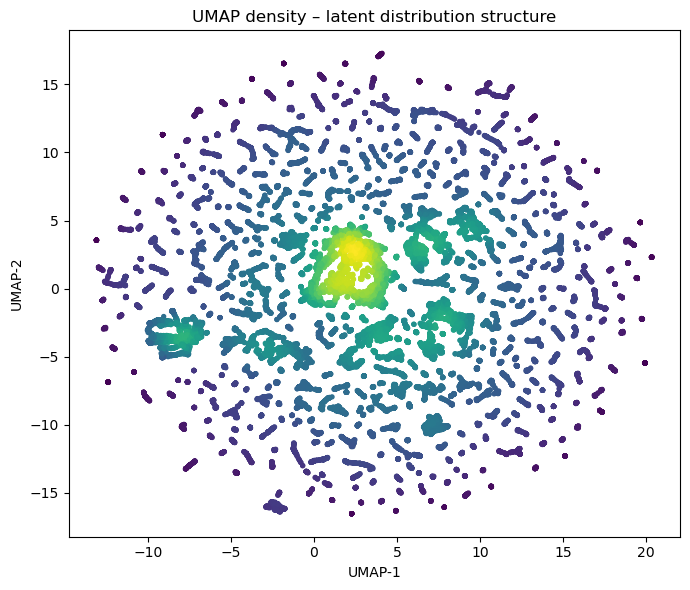

In [18]:
#UMAP KDE density contours
from scipy.stats import gaussian_kde

plt.figure(figsize=(7, 6))
xy = latents_umap.T
kde = gaussian_kde(xy)(xy)

plt.scatter(
    latents_umap[:,0], latents_umap[:,1],
    c=kde, s=8, cmap="viridis"
)
plt.title("UMAP density – latent distribution structure")
plt.xlabel("UMAP-1"); plt.ylabel("UMAP-2")
plt.tight_layout()
plt.show()


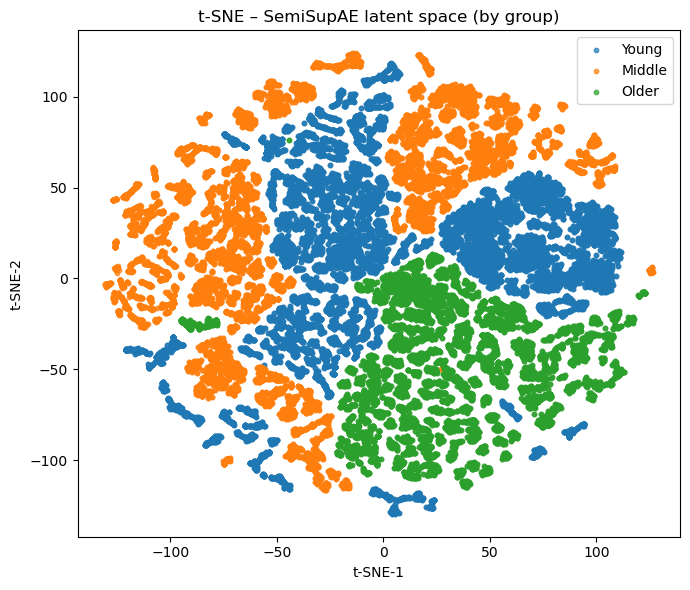

In [21]:
# To visualize the clustering results with t-SNE
# ─── t-SNE visualization ─────────────────────────────────────────────────
tsne_model = TSNE(
    n_components=2,
    perplexity=30,
    learning_rate=2000,
    init="random",
    random_state=42,
)

latents_tsne = tsne_model.fit_transform(latents)

plt.figure(figsize=(7, 6))
for g, name in zip([1,2,3], ["Young", "Middle", "Older"]):
    mask = (groups == g)
    plt.scatter(
        latents_tsne[mask, 0],
        latents_tsne[mask, 1],
        s=10,
        alpha=0.7,
        label=name,
    )

plt.title("t-SNE – SemiSupAE latent space (by group)")
plt.xlabel("t-SNE-1"); plt.ylabel("t-SNE-2")
plt.legend()
plt.tight_layout()
plt.show()



Separabilidad supervisada simple (muy estándar en representación learning)

No es clustering, pero se ve muy bien en un paper:

Tomas el espacio latente congelado.

Entrenas un clasificador lineal sencillo (Logistic Regression / Linear SVM) para predecir:

grupos (young/middle/old)

y/o sujeto.

Métrica: accuracy, F1, ROC-AUC (one-vs-rest).

Mensaje que puedes vender:

“A linear probe trained on top of the latent space achieves XX% accuracy in discriminating age groups, indicating that the semi-supervised AE learns linearly separable, group-discriminative representations.”

“To evaluate linear separability of the latent space, we trained a multinomial logistic regression classifier (‘linear probe’) on top of the frozen embeddings.
High accuracy, macro-F1, and ROC-AUC values indicate that the SemiSupAE latent space encodes age-group discriminative structure that is directly separable by a linear decision boundary, consistent with previous representation learning literature.”

In [ ]:
# ─── Linear probe: Logistic Regression on latent space ───────────────────

# =============================================================
# SUBJECT-WISE SPLIT (MUY IMPORTANTE)
# =============================================================

# 1. IDs únicos de sujeto
unique_subjects = np.unique(subject_ids)

# 2. Grupo por sujeto (cada sujeto pertenece a un grupo)
subject_groups = []
for s in unique_subjects:
    gs = np.unique(groups[subject_ids == s])
    assert len(gs) == 1, f"Sujeto {s} tiene múltiples grupos en meta."
    subject_groups.append(gs[0])
subject_groups = np.array(subject_groups)

# 3. División sujeto-wise estratificada por grupo
train_subj, test_subj = train_test_split(
    unique_subjects,
    test_size=0.20,
    stratify=subject_groups,
    random_state=42
)

# 4. Máscaras por sujeto
train_mask = np.isin(subject_ids, train_subj)
test_mask  = np.isin(subject_ids, test_subj)

# 5. Construcción de sets para el linear probe
X_train = latents[train_mask]
X_test  = latents[test_mask]
y_train = groups[train_mask]
y_test  = groups[test_mask]

print("Train shape:", X_train.shape, "Test shape:", X_test.shape)
print("Unique y_train:", np.unique(y_train))
print("Unique y_test:",  np.unique(y_test))

# =============================================================
# LINEAR PROBE: Logistic Regression
# =============================================================

clf = LogisticRegression(
    multi_class="multinomial",
    solver="lbfgs",
    max_iter=2000,
)

clf.fit(X_train, y_train)

y_pred  = clf.predict(X_test)
y_proba = clf.predict_proba(X_test)

acc = accuracy_score(y_test, y_pred)
f1  = f1_score(y_test, y_pred, average="macro")

y_test_bin = label_binarize(y_test, classes=[1,2,3])
roc = roc_auc_score(y_test_bin, y_proba, multi_class="ovr")

print("\n=== SUBJECT-WISE Linear Probe (Logistic Regression) ===")
print(f"Accuracy:  {acc:.4f}")
print(f"Macro F1:  {f1:.4f}")
print(f"ROC-AUC:   {roc:.4f}")



Train shape: (43940, 128) Test shape: (17500, 128)
Unique y_train: [1 2 3]
Unique y_test: [1 2 3]

=== SUBJECT-WISE Linear Probe (Logistic Regression) ===
Accuracy:  0.1551
Macro F1:  0.1761
ROC-AUC:   0.5668


/home/dmartinez/miniconda3/envs/gait_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


: 

In [ ]:
### Despues mas robusta 
# ─── Linear probe with stratified 5-fold cross-validation ─────────────────

from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from sklearn.preprocessing import label_binarize
import numpy as np

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

accs, f1s, rocs = [], [], []

for train_idx, test_idx in kf.split(latents, groups):
    X_train, X_test = latents[train_idx], latents[test_idx]
    y_train, y_test = groups[train_idx], groups[test_idx]

    clf = LogisticRegression(
        multi_class="multinomial",
        solver="lbfgs",
        max_iter=2000,
    )
    clf.fit(X_train, y_train)

    y_pred  = clf.predict(X_test)
    y_proba = clf.predict_proba(X_test)

    accs.append(accuracy_score(y_test, y_pred))
    f1s.append(f1_score(y_test, y_pred, average="macro"))

    y_bin = label_binarize(y_test, classes=[0,1,2])
    rocs.append(roc_auc_score(y_bin, y_proba, multi_class="ovr"))

print("\n=== 5-Fold Linear Probe (Logistic Regression) ===")
print(f"Accuracy:  {np.mean(accs):.4f} ± {np.std(accs):.4f}")
print(f"Macro F1:  {np.mean(f1s):.4f} ± {np.std(f1s):.4f}")
print(f"ROC-AUC:   {np.mean(rocs):.4f} ± {np.std(rocs):.4f}")


# Clustering per patient 

In [8]:
import numpy as np
import torch
from hdbscan import HDBSCAN
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
from collections import Counter
import pandas as pd
import umap
import matplotlib.pyplot as plt


In [9]:
print(type(model.encoder(x)))


NameError: name 'x' is not defined

In [10]:
# --------------------------------------
# 1. Extract latents and patient labels
# --------------------------------------
latents_list = []
true_labels_list = []

model.eval()
with torch.no_grad():
    for x_batch, meta in test_loader:

        # 1.1 Move to device
        x = x_batch.to(device)

        # 1.2 Meta -> (B, features_meta, T)
        # If your meta is already in (B, 1, T) skip this
        meta = meta.permute(0, 2, 1)

        # 1.3 Extract patient IDs
        # We assume patient ID is constant in time → meta[:, 0, 0]
        patient_ids = meta[:, 0, 0].cpu().numpy().astype(int)

        # 1.4 Encode latent representation
        z = model.encoder(x)        # (B, latent_dim)

        latents_list.append(z.cpu().numpy())
        true_labels_list.append(patient_ids)

# Concat
latents = np.concatenate(latents_list, axis=0)
y_true  = np.concatenate(true_labels_list, axis=0)

print("Latents shape:", latents.shape)
print("True labels shape:", y_true.shape)

Latents shape: (61142, 128)
True labels shape: (61142,)


In [11]:
# --------------------------------------
# 2. Clustering with HDBSCAN
# --------------------------------------
clusterer = HDBSCAN(min_cluster_size=3, min_samples=3)
y_pred = clusterer.fit_predict(latents)

/home/dmartinez/miniconda3/envs/gait_env/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/dmartinez/miniconda3/envs/gait_env/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [12]:
# --------------------------------------
# 3. Metrics
# --------------------------------------
ari = adjusted_rand_score(y_true, y_pred)
nmi = normalized_mutual_info_score(y_true, y_pred)

print(f"ARI: {ari:.3f}")
print(f"NMI: {nmi:.3f}")

ARI: 0.013
NMI: 0.456


In [13]:
# --------------------------------------
# 4. Purity by patient
# --------------------------------------
def purity_by_patient(y_true, y_pred):
    purities = {}
    for p in np.unique(y_true):
        mask = (y_true == p)
        clusters_p = y_pred[mask]
        if clusters_p.size == 0:
            purities[p] = np.nan
        else:
            most_common, count = Counter(clusters_p).most_common(1)[0]
            purities[p] = count / clusters_p.size
    return purities

pur = purity_by_patient(y_true, y_pred)
avg_purity = np.nanmean(list(pur.values()))

print(f"Avg purity: {avg_purity:.2%}")
for p, v in pur.items():
    print(f"  Patient {p}: {v:.2%}")

Avg purity: 26.95%
  Patient 2: 16.70%
  Patient 8: 18.07%
  Patient 13: 23.73%
  Patient 18: 49.06%
  Patient 21: 29.16%
  Patient 42: 35.33%
  Patient 49: 23.00%
  Patient 50: 32.10%
  Patient 75: 25.90%
  Patient 76: 24.67%
  Patient 82: 39.87%
  Patient 104: 15.84%
  Patient 107: 27.05%
  Patient 119: 23.48%
  Patient 120: 23.40%
  Patient 125: 25.59%
  Patient 175: 25.12%


In [14]:
# --------------------------------------
# 5. Contingency matrix
# --------------------------------------
conf_mat = pd.crosstab(y_true, y_pred,
                       rownames=['Patient'],
                       colnames=['Cluster'])

print(conf_mat)

Cluster  -1      0      1      2      3      4      5      6      7      8     \
Patient                                                                         
2          527      0      0      0      0      0      0      0      0      0   
8          717      0      0      0      0      0      0      0      0      0   
13         852      0      0      0      0      0      0      0      0      0   
18        1876      0      0      0      0      0      0      0      0      0   
21         988      0      0      0      0      0      0      0      0      0   
42        1260      4      0      0      0      0      0      0      0      0   
49         755      0      0      0      0      0      0      0      0      0   
50        1243      2      0      0      0      0      0      0      0      0   
75        1133      0      0      0      0      0      0      0      0      0   
76        1146      0      0      0      0      0      0      0      0      0   
82        1409      0     49

In [15]:
# --------------------------------------
# 6. Hyperparameter search (HDBSCAN)
# --------------------------------------
min_sizes   = [3, 5, 10, 20]
min_samples = [1, 3, 5, None]

results = []
for mcs in min_sizes:
    for ms in min_samples:
        hdb = HDBSCAN(min_cluster_size=mcs,
                      min_samples=ms if ms is not None else mcs)
        y_p = hdb.fit_predict(latents)
        ari = adjusted_rand_score(y_true, y_p)
        nmi = normalized_mutual_info_score(y_true, y_p)
        pur = np.nanmean(list(purity_by_patient(y_true, y_p).values()))
        results.append((mcs, ms, ari, nmi, pur))

df = pd.DataFrame(results, columns=[
    "min_cluster_size", "min_samples", "ARI", "NMI", "purity_avg"
])
print(df.sort_values("ARI", ascending=False))

/home/dmartinez/miniconda3/envs/gait_env/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/dmartinez/miniconda3/envs/gait_env/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/dmartinez/miniconda3/envs/gait_env/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/dmartinez/miniconda3/envs/gait_env/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/dmartinez/miniconda3/envs/gait_env/lib/python3.10/site-packages/sklearn/utils/deprecation.py:1

    min_cluster_size  min_samples       ARI       NMI  purity_avg
12                20          1.0  0.369212  0.635240    0.447776
14                20          5.0  0.339625  0.637034    0.509481
13                20          3.0  0.338462  0.629662    0.474467
11                10          NaN  0.335104  0.645462    0.597268
10                10          5.0  0.275695  0.597138    0.481931
9                 10          3.0  0.268198  0.588058    0.427944
8                 10          1.0  0.242280  0.571987    0.356113
15                20          NaN  0.242252  0.643021    0.582123
4                  5          1.0  0.083527  0.504604    0.262689
5                  5          3.0  0.071314  0.495689    0.314619
6                  5          5.0  0.067021  0.498461    0.360379
7                  5          NaN  0.067021  0.498461    0.360379
2                  3          5.0  0.062785  0.490335    0.370909
1                  3          3.0  0.012765  0.456029    0.269456
3         

In [ ]:
# --------------------------------------
# 7. UMAP visualization
# --------------------------------------
umap_model = umap.UMAP(n_neighbors=15, min_dist=0.1, metric='euclidean')
latent_2d = umap_model.fit_transform(latents)

plt.figure(figsize=(10, 8))
plt.scatter(latent_2d[:, 0], latent_2d[:, 1], c=y_true, cmap='tab20', s=5)
plt.title("UMAP projection - color by patient ID")
plt.colorbar(label="Patient ID")
plt.show()